In [106]:
import os
from dotenv import load_dotenv
load_dotenv('../.flaskenv')

True

In [107]:
from pathlib import Path
Home = str(Path.home())

import numpy as np
import pandas as pd

import sys
path = f'{Home}/repos/EPObjects/'
sys.path.insert(0, path)

from probabilistic.probabilistic_parameters import ProbabilisticParameters
from probabilistic.energy_predictions import EnergyPrediction, ProbabilisticEnergyPrediction
from ml_models import get_scaling_layer

from helper.run_period import get_run_periods

from service import db_functions as db

import matplotlib.pyplot as plt

In [108]:
solid_colors = ['#1f77b4', '#d62728', '#9467bd', '#2ca02c', '#ff7f0e',]
num_solid_colors = len(solid_colors)

def rgb_to_hex(c):
    c = c.astype(np.int16)
    return '#%02x%02x%02x' %(c[0], c[1], c[2])

def hex_to_rg(h):
    return np.array([int(h[i:i+2], base=16) for i in (1, 3, 5)], dtype=np.int16)

def get_weighed_color(col1, col2='#ffffff', w=0.5):
    c1 = hex_to_rg(col1)
    c2 = hex_to_rg(col2)
    return rgb_to_hex((c1 * (1-w)) + (w * c2))

class ColorScale:
    def __init__(self, c1, c2, mi, ma):
        self.Color1 = c1
        self.Color2 = c2
        self.Min = mi
        self.Max = ma
        self.Range = self.Max - self.Min

    def scale(self, value):
        return (value-self.Min)/self.Range
        
    def color(self, value):
        if isinstance(value, np.ndarray):
            vs = []
            for v in value:
                vs.append(get_weighed_color(self.Color1, self.Color2, self.scale(v)))
            return vs
        return get_weighed_color(self.Color1, self.Color2, self.scale(value))
    
trans_colors = [get_weighed_color(x, w=0.2) for x in solid_colors]

In [133]:
mapping = {
    "u-value:WallExternal": "u-value:Wall\n(W/m\u00b2K)",
    "u-value:FloorGround": "u-value:Floor\n(W/m\u00b2K)",
    "u-value:Roof": "u-value:Roof\n(W/m\u00b2K)",
    "u-value:Window": "u-value:Window\n(W/m\u00b2K)",
    "g-value:Window": "g-value (-)",
    "u-value:Glazing": "u-value:Window\n(W/m\u00b2K)",
    "g-value:Glazing": "g-value (-)",
    "Permeability": "Peremability\n(m\u00b3/m\u00b2h)",
    "HeatingSP": "Setpoint (C)",
    "HeatingCOP": "Coefficient of\nperformance (-)",
    'Occupancy:Office': "Occupancy\n(Person/m\u00b2)",
    'InternalMass:Office': "Internal Mass\n(W/m\u00b2)", 
    'LightHeatGain:Office': 'Lights\n(W/m\u00b2)',
    'EquipmentHeatGain:Office': 'Equipment\n(W/m\u00b2)',
    'InternalMass': 'Internal Mass\n(kJ/m\u00b2K)',
    'BoilerEfficiency': 'Boiler\nEfficiency (-)',
    'WeeklyHours': 'Hours (hr/week)'
    }

def get_name_mapping(name):
    return mapping.get(name, '-')

In [154]:
user_name = 'tum-gni'
proj_name = 'house-in'

search_conditions = db.get_search_conditions(user_name, proj_name)
pps = db.get_columns(search_conditions, db.PARAMETERS, convert_to_df=True)
pps = ProbabilisticParameters.from_df(pps)
scaling_df_X = pps.get_scaling_df()
scaling_x = get_scaling_layer(scaled_df=scaling_df_X)

consumption_df = db.get_columns(search_conditions, db.CONSUMPTION, True)
run_periods, targets = get_run_periods(consumption_df)

simulation_results = db.get_columns(search_conditions, db.SIMULATION_RESULTS,)
simulation_results = ProbabilisticEnergyPrediction.from_json(simulation_results)
simulation_results = simulation_results.Values['Total']

results = db.get_columns(search_conditions, db.RESULTS,)

combinations = pd.DataFrame.from_dict(results[db.PARAMETERS])[:10]
predictions = pd.DataFrame.from_dict(results[db.PREDICTIONS])[:10]

scaling_data = db.get_columns(search_conditions, db.SCALING)
scaling_df_Y = pd.DataFrame.from_dict(scaling_data[db.SCALING_DF_Y])
scaling_y = get_scaling_layer(scaled_df=scaling_df_Y)

In [149]:
def plot_multiaxis(ax, pps):
    for i, pp in enumerate(pps):
        ax.plot([i, i], [0, 1], lw=1, ls='--', color='k', zorder=10)
        ax.plot(i * np.ones((6)), np.linspace(0, 1, 6), marker='_', markersize=5, color='#aaaaaa', lw=0.1)
        
        ax.text(i, -0.04, f'{pp.Min:.02f}', size=8, horizontalalignment='center')
        ax.text(i, 1.07, f'{pp.Max:.02f}', size=8, horizontalalignment='center', verticalalignment='top')
        ax.plot([i, i], [-0.01, 1.01], lw=0.5, ls='-.', color='k', zorder=1)


def plot_results_scale(ax, results_pos, error_scale):
    size = 0.5
    consumption_scale = ColorScale('#bbbbbb', '#ff7f0e', 0, 1.0)
    breaks = 10
    for i, t in enumerate(scaling_df_Y.iterrows()):
        plt.text(results_pos+0.2, i*size, t[0], horizontalalignment='left', size=8, rotation=90)
        for j in range(breaks):
            ax.plot([results_pos, results_pos], [i*size + j*0.4/breaks, i*size + (j+1) * 0.4/breaks], lw=2, ls='-', color=consumption_scale.color(j/breaks), zorder=1)
            if i==0:
                ax.plot([results_pos+1, results_pos+1], [i*size + j*0.4/breaks, i*size + (j+1) * 0.4/breaks], lw=2, ls='-', color=consumption_scale.color(j/breaks), zorder=1)
    
    increment = error_scale.Range/breaks
    for j in np.linspace(error_scale.Min, error_scale.Max, breaks):
        y_start = 0.5 + error_scale.scale(j) * 0.4 
        y_end = 0.5 + error_scale.scale(j+increment) * 0.4
        ax.plot([results_pos+1, results_pos+1], [y_start, y_end], lw=2, ls='-', color=error_scale.color(j), zorder=1)
    # break

    ax.text(results_pos+1.2, 0.5, f'{error_scale.Min:0.0f} %', size=8)
    ax.text(results_pos+1.3, 0.6, f'Difference\nfrom\nMeasured', size=8)
    ax.text(results_pos+1.2, 0.9, f'{error_scale.Max:0.0f} %', size=8)

    ax.text(results_pos+1.2, 0, f'{scaling_df_Y["Min"][0]/1000:.02f} MWh', size=8)
    ax.text(results_pos+1.3, 0.1, f'Annual\nEnergy\nUse', size=8)
    ax.text(results_pos+1.2, 0.4, f'{scaling_df_Y["Max"][0]/1000:.02f}', size=8)


def plot_results(ax, x, y, error_scale, errors, total_error):
    size = 0.5
    for i, chr in enumerate(x):
        previous = None
        for p, x1 in enumerate(chr):
            if previous is not None:
                ax.plot([previous[0], p], [previous[1], x1], lw=0.5, ls='--', color=error_scale.color(total_error[i]), zorder=-1)
            previous = [p, x1]
        
        for j, t in enumerate(y[i]):
            ax.plot([previous[0], p+1.0], [previous[1], j*size + t], lw=0.5, ls='--', color=error_scale.color(errors[i, j]), zorder=-1)
    return p


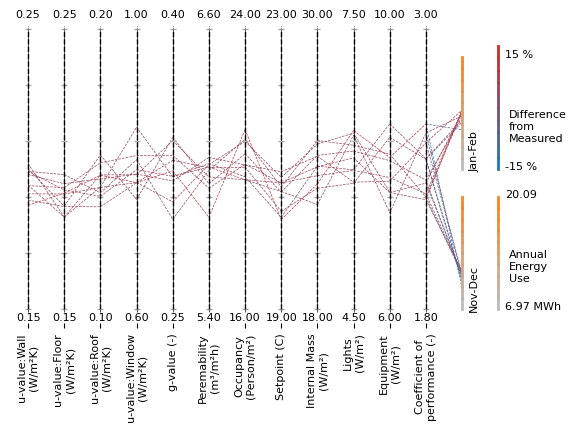

In [150]:
fig, ax = plt.subplots(figsize=(0.5 * len(scaling_df_X) + 1, 4), nrows = 1, ncols = 1)
x = scaling_x(combinations).numpy()
y = scaling_y(predictions).numpy()*0.4

errors = pd.DataFrame.from_dict(results[db.ERRORS]).values
total_error = list(results[db.TOTAL_ERROR].values())

error_scale = ColorScale('#1f77b4', '#d62728', min(errors.min(), min(total_error)), max(errors.max(), max(total_error)))

p = plot_results(ax, x, y, error_scale, errors, total_error)
plot_multiaxis(ax, pps)

results_pos = p+1.0
plot_results_scale(ax, results_pos, error_scale)

xticks = tuple(get_name_mapping(x) for x in pps.get_scaling_df().index)
ax.set_xticks([x for x in range(len(xticks))], labels=xticks, size=8, rotation=90,)# horizontalalignment='center', verticalalignment='center')
ax.set_yticks([])
ax.set_ylim([-0.05, 1.05])
ax.set_xlim([-.5, results_pos+2.5])

ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
plt.grid(False)

plt.savefig(f'{user_name}-{proj_name}-parameters.pdf', bbox_inches='tight')

In [151]:
pps.get_scaling_df()

,Min,Range
u-value:WallExternal,0.15,0.10
u-value:FloorGround,0.15,0.10
u-value:Roof,0.10,0.10
u-value:Window,0.60,0.40
g-value:Window,0.25,0.15
Permeability,5.40,1.20
Occupancy:Office,16.00,8.00
HeatingSP,19.00,4.00
InternalMass:Office,18.00,12.00
LightHeatGain:Office,4.50,3.00


In [155]:
combinations

,u-value:WallExternal,u-value:Roof,u-value:Glazing,g-value:Glazing,Permeability,WeeklyHours,InternalMass,HeatingSP,BoilerEfficiency
0,0.740146,0.349472,2.480488,0.649881,7.519767,110.213409,19.836327,16.968105,0.920079
